In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud as wc

from string import punctuation as p
from collections import Counter as cnt 
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as lemma
from nltk.corpus import stopwords
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer



from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split,GridSearchCV as gsv
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,\
confusion_matrix,log_loss,precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
#importing training file
train=pd.read_csv(r"D:\Fliprobo\projects\projects\Project_1\train.csv")

In [3]:
train.head(4)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy


In [4]:
train.shape

(38932, 5)

In [5]:
#null value checking
train.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

In [6]:
#renaming the coulumn
train.rename(columns={"Is_Response":'response'},inplace=True)

In [7]:
#checking unique values in response column and their count
u_val=train['response'].nunique()
vc=train['response'].value_counts()
print('In',train.columns.values[-1].upper(),'there are',u_val,'unique values.Their counts are\n',vc)

In RESPONSE there are 2 unique values.Their counts are
 happy        26521
not happy    12411
Name: response, dtype: int64


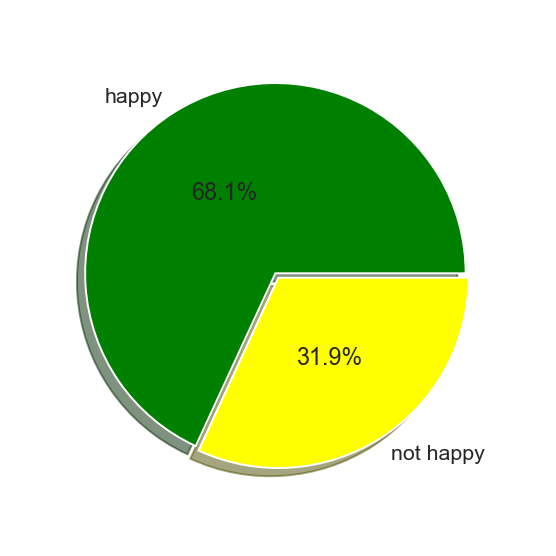

In [8]:
lb=train['response'].value_counts().index.tolist()
val=train['response'].value_counts().values.tolist()
exp=(0.025,0)
clr=('green','yellow')
plt.figure(figsize=(10,5),dpi=140)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=val,explode=exp,labels=lb,colors=clr,autopct='%2.1f%%',pctdistance=0.5, shadow=True,radius=0.9)
plt.show()

In [9]:
train.describe()

,User_ID,Description,Browser_Used,Device_Used,response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id47244,Upon arrival in the a.m. well prior to check i...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [10]:
#DROPPING UNWANTED
train.drop(['User_ID','Browser_Used','Device_Used'],axis=1,inplace=True)

In [11]:
#CREATING A COLUMN TO CHECK THE LENGTH OF EACH ROW OF DESCRIPTION COLUMN
train['len_uncleaned desc']=train['Description'].str.len()
train.head(3)

,Description,response,len_uncleaned desc
0,The room was kind of clean but had a VERY stro...,not happy,248
1,I stayed at the Crown Plaza April -- - April -...,not happy,1077
2,I booked this hotel through Hotwire at the low...,not happy,1327


In [12]:
#LABEL ENCODING USING MAP FUNCTION
remap={'happy':1,'not happy':0}
train['response']=train['response'].map(remap)

In [13]:
#CONVRTING EVERYTHING TO LOWERCASE
train['Description']=train['Description'].str.lower()

#REPLACING NEXT LINES BY WHITE SPACE
train['Description']=train['Description'].str.replace(r'\n'," ") 

#REPLACING SPECIAL CHARACTERS AND NUMBERS BY WHITE SPACE IT ALSO REMOVES THE PUNCTUATIONS
train['Description']=train['Description'].str.replace(r"[^a-zA-Z]+", " ") #removing all special characters

In [14]:
#PREVIEW AFTER LOWER CASE CONVERSION AND REMOVAL OF UNWANTED CHARACTERS
print(train['Description'][2:8])

2    i booked this hotel through hotwire at the low...
3    stayed here with husband and sons on the way t...
4    my girlfriends and i stayed here to celebrate ...
5    we had rooms one was very nice and clearly had...
6    my husband and i have stayed in this hotel a f...
7    my wife i stayed in this glorious city a while...
Name: Description, dtype: object


In [15]:
#CREATING A FUNCTION FOR REMOVING STOPWORDS, PUNCTUATION MARKS AND  CREATING WORD TOKEN AND LEMMATIZING THEM
def clean(text):
    cleaned=[]
    for i in wt(text):
        if i not in p:
            if not i in stopwords.words('english') and len(i)>=2:
                cleaned.append(lemma().lemmatize(i,pos='v')) 
    return (" ".join([x for x in cleaned])).strip()

In [16]:
#TESTING THE FUNCTION
text="But look! here come more crowds, pacing straight for the water, and seemingly bound for a dive. Strange! Nothing\
will content them but theextremest limit of the land; loitering under the shady lee of yonderwarehouses will not suffice.\
No. They must get just as nigh the water asthey possibly can without falling And there they stand- miles of them-leagues. \
Inlanders all, they come from lanes and alleys, streets avenues-north, east, south, and west. Yet here they all unite. \
Tell me, does themagnetic virtue of the needles of the compasses of all those ships attractthem thither?"
text=text.lower()
print(clean(text))

look come crowd pace straight water seemingly bind dive strange nothingwill content theextremest limit land loiter shady lee yonderwarehouses suffice.no must get nigh water asthey possibly without fall stand- miles them-leagues inlanders come lanes alleys streets avenues-north east south west yet unite tell themagnetic virtue needle compass ship attractthem thither


In [17]:
%%time
cleaned = []

for i in train['Description']:
    cleaned.append(clean(i))

Wall time: 20min 25s


In [18]:
print("Length of cleaned text=\t",len(cleaned))
print(cleaned[:3])

Length of cleaned text=	 38932
['room kind clean strong smell dog generally average ok overnight stay fussy would consider stay price right breakfast free better nothing', 'stay crown plaza april april staff friendly attentive elevators tiny food restaurant delicious price little high side course washington dc pool little children room fifth floor two comfortable bed plenty space one person tv little small todays standards limit number channel small bite mold bathtub area could remove little bleach appear carpet vacummed every day report light bulb burn never replace ice machine odd number floor one floor work encounter staff elevator one even mention ice machine severel hours later maid appear door ice two mint sure know room little unnerve would stay business would come vacation', 'book hotel hotwire lowest price could find get front desk manager give us smoke room argue little baby would book room know smoke manager would hear anything tell hotwire book cheapest room available get g

In [19]:
#ADDING THE EXTRACTED FEATURES TO THE DATAFRAME
processed = pd.DataFrame({'cleaned_description' : cleaned })
train = pd.concat([train, processed], axis = 1)
train['len_cleaned_description']=train['cleaned_description'].str.len()
train.sample(5)

,Description,response,len_uncleaned desc,cleaned_description,len_cleaned_description
15053,the hotel is very impressive and attractive fr...,0,1029,hotel impressive attractive outside inside bit...,594
27032,stayed for nights at the hyatt for our first v...,1,1166,stay nights hyatt first visit chicago check qu...,704
36244,i have stayed at this hotel several times when...,1,465,stay hotel several time visit chicago busy ama...,298
38917,i love this hotel and will stay again for seve...,1,916,love hotel stay several reason despite one gri...,591
35714,i really wanted a specific room type since i v...,1,449,really want specific room type since visit hot...,264


In [20]:
#CALCULATING
print('Original Length = ', train['len_uncleaned desc'].sum())
print('Clean Length =  ', train['len_cleaned_description'].sum())
print('Total Reduction = ',train['len_uncleaned desc'].sum()-train['len_cleaned_description'].sum())

Original Length =  33725876
Clean Length =   19544373
Total Reduction =  14181503


In [21]:
#WORD CLOUDS TO CHECK HIGH FREQUENCY WORDS FOR HAPPY

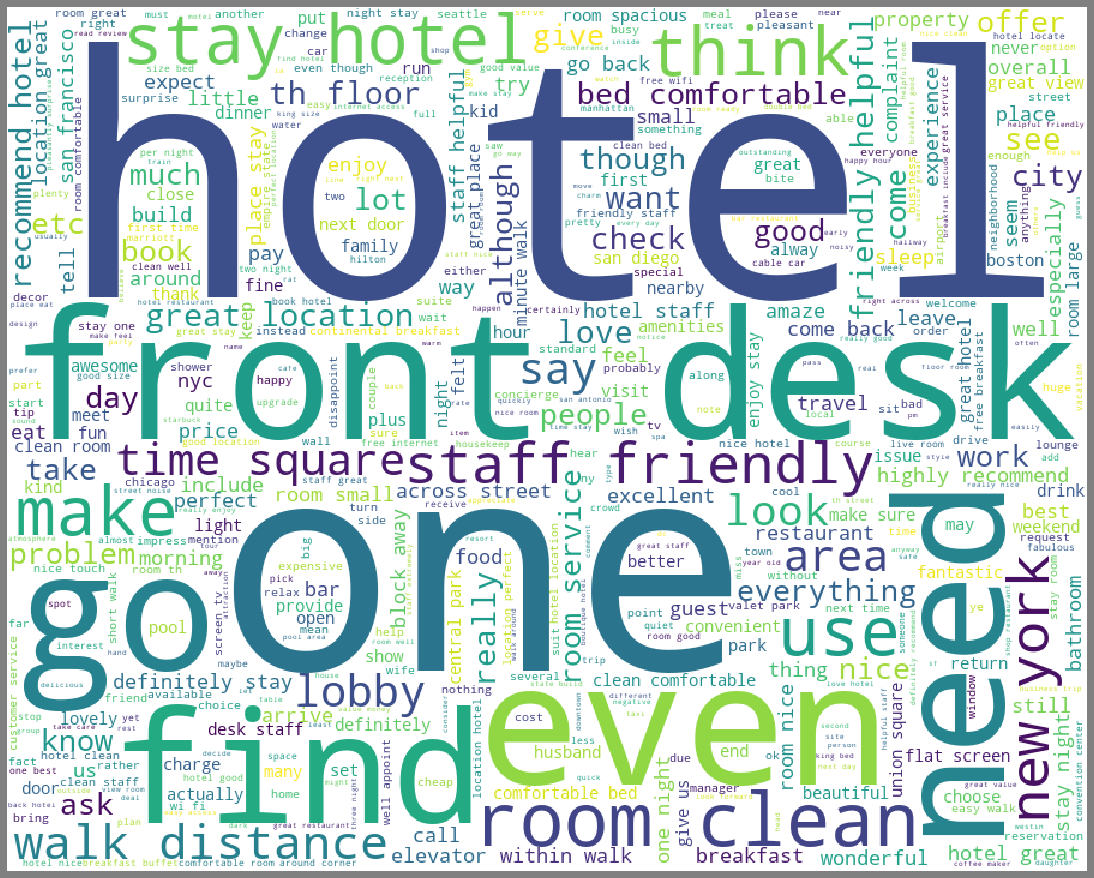

In [22]:
happy = train['cleaned_description'][train['response']==1]
happy_cloud = wc(width=900,height=720,background_color='white',max_words=500).generate(' '.join(happy))
plt.figure(figsize=(15,18),facecolor='grey')
plt.imshow(happy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [23]:
#WORD CLOUDS TO CHECK HIGH FREQUENCY WORDS FOR NOT HAPPY

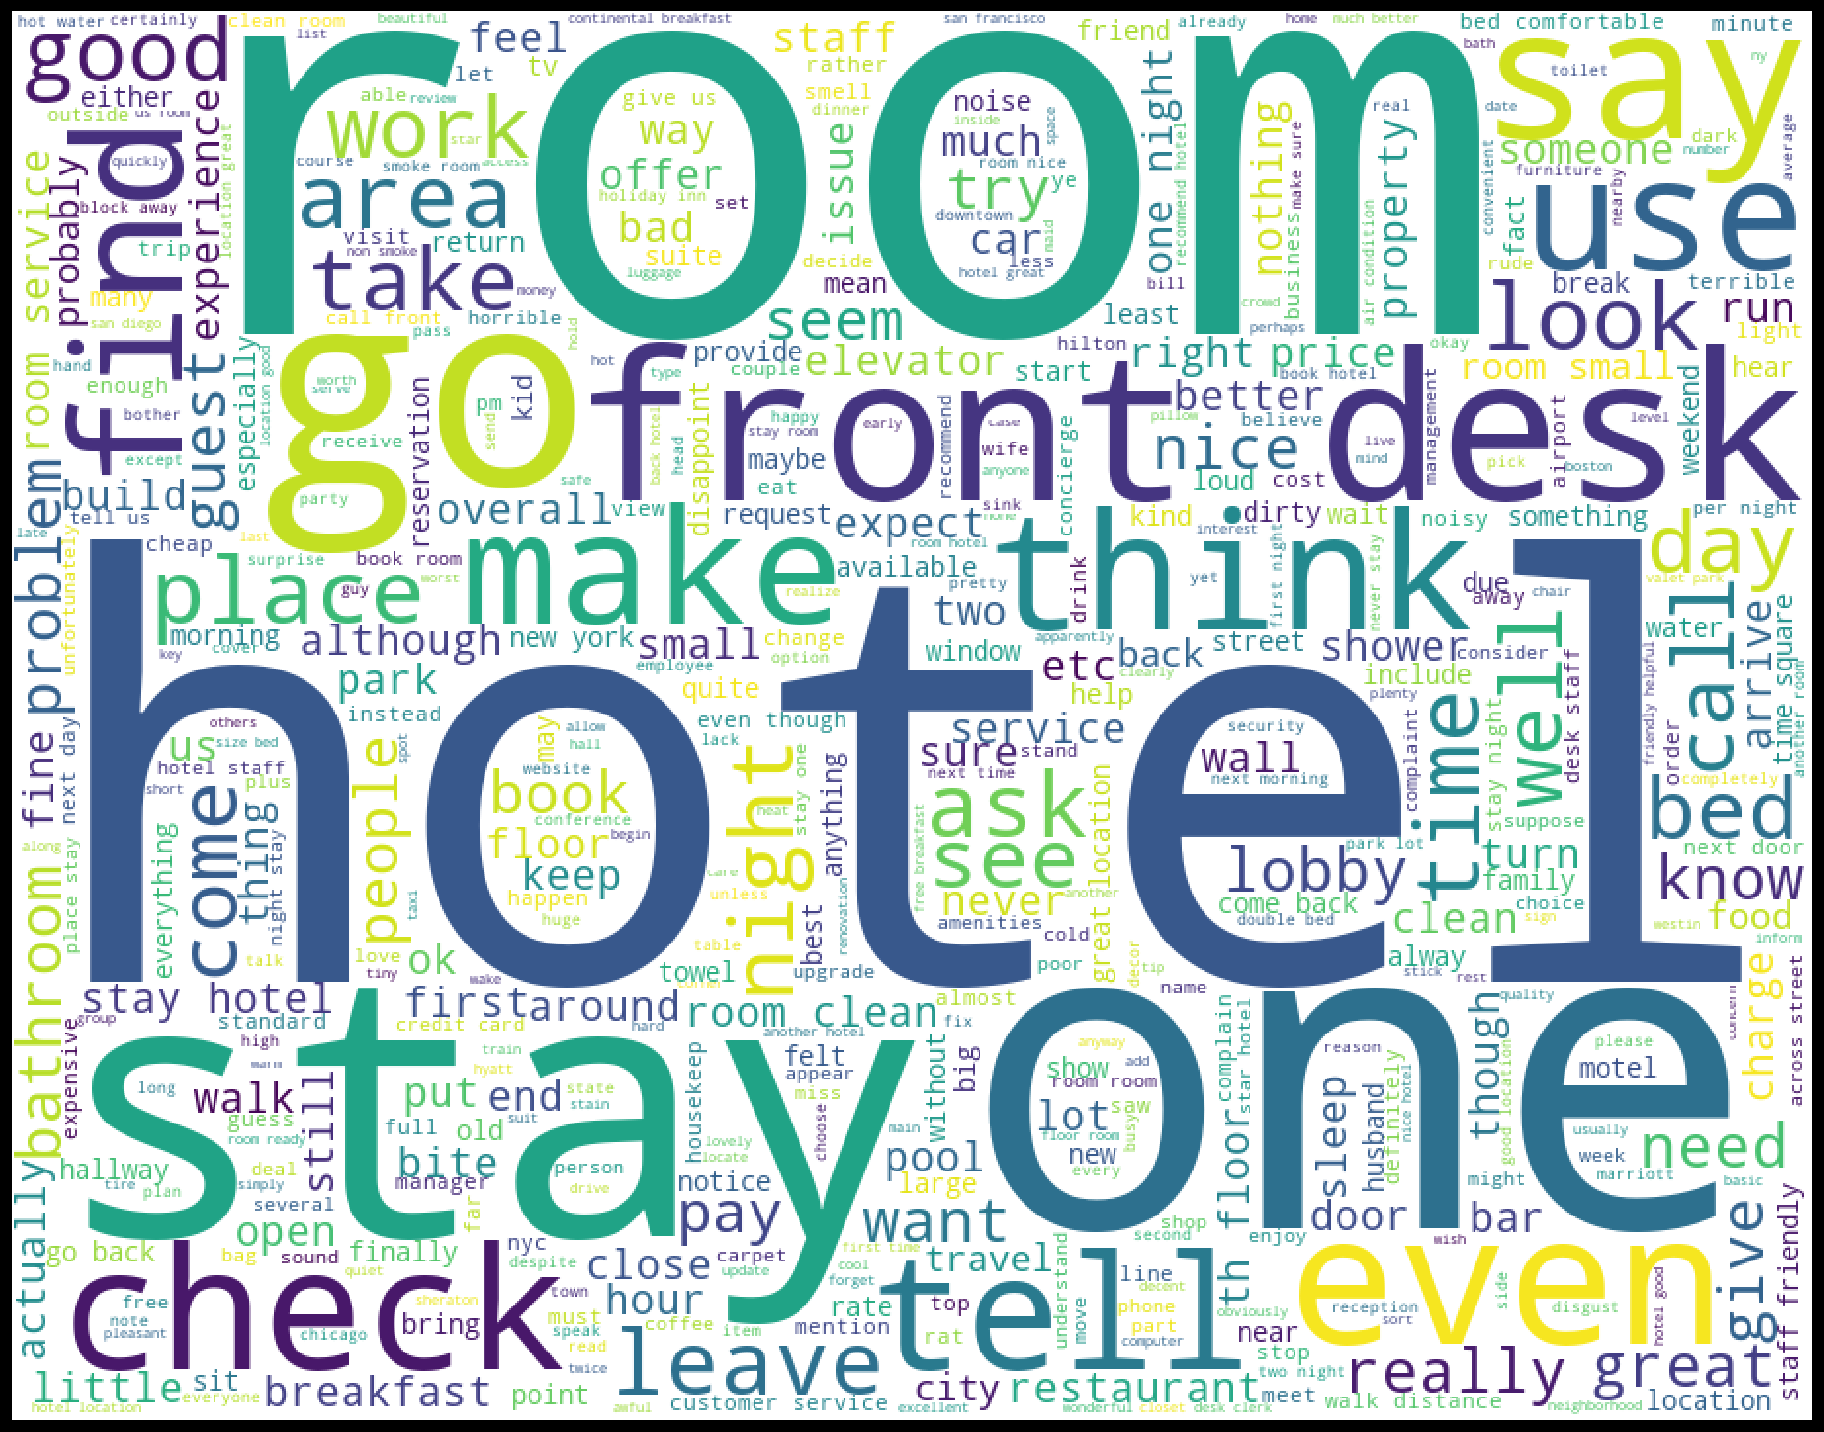

In [24]:
unhappy = train['cleaned_description'][train['response']==0]
unhappy_cloud = wc(width=920,height=720,background_color='white',max_words=500).generate(' '.join(unhappy))
plt.figure(figsize=(15,18),facecolor='black',dpi=120)
plt.imshow(unhappy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [25]:
#Modeling

In [26]:
y=train['response']

x=tfidf(input='content', encoding='utf-8', lowercase=True,stop_words='english').fit_transform(train['cleaned_description'])
x

<38932x38774 sparse matrix of type '<class 'numpy.float64'>'
	with 2136756 stored elements in Compressed Sparse Row format>

In [27]:
ACCURACY = []
PRECISION = []
RECALL = []
RMSE = []
MSE = []
ROC_AUC=[]

def acusr(model,x,y):
    max_ac=0
    for rst in range(25,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=rst)
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        acc=accuracy_score(pred,y_test)
        clr=classification_report(y_test,pred)
        conf=confusion_matrix(y_test,pred)
        pre=precision_score(y_test,pred)
        rec=recall_score(y_test,pred)
        mse=mean_squared_error(y_test,pred)
        rmse=np.sqrt(mse)
        fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        if acc>max_ac:
            max_ac=acc
            final_rst=rst
         
    print("In this",model,"\nRANDOM STATE:\n",final_rst)
    print('\nACCURACY SCORE:\n', max_ac)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nCONFUSION MATRIX:\n',conf)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)

    #ADDING VALUES TO LIST
    ACCURACY.append(acc)
    PRECISION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    ROC_AUC.append(roc_auc)
    
   
    #PLOTTING auc_roc CURVE
    sns.set(style='whitegrid',context='talk',font_scale=0.7)
    plt.figure(figsize=(8,7),dpi=120)
    plt.plot([0,1],[0,1],color='aquamarine',linestyle=":",lw=3)
    plt.plot(fpr,tpr,label="AUC= %0.2f" % roc_auc,color='dodgerblue',lw=3,linestyle='--')
    plt.legend(loc='lower right',fontsize='medium',shadow=True)
    plt.xlabel("FPR")
    plt.ylabel('TPR')
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE',size=15,weight='bold',loc='center')
    plt.show()
    
    
    #PLOTTING CONFUSION MATRIX
    plt.figure(figsize=(6,4),dpi=120)
    sns.heatmap(conf,annot=True,cmap='Blues')
    plt.title('HEATMAP OF CONFUSION MATRIX')
    plt.show()

In [28]:
#LOGISTIC REGRESSION

In this LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True) 
RANDOM STATE:
 50

ACCURACY SCORE:
 0.8849315068493151

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      3699
           1       0.89      0.94      0.91      7981

    accuracy                           0.88     11680
   macro avg       0.87      0.84      0.86     11680
weighted avg       0.88      0.88      0.88     11680


CONFUSION MATRIX:
 [[2763  936]
 [ 462 7519]]

PRECISION:
 0.8892962743938498

RECALL:
 0.9421125172284175

MEAN SQUARED ERROR:
 0.11969178082191781

ROOT MEAN SQ. ERROR:
 0.34596499941745235


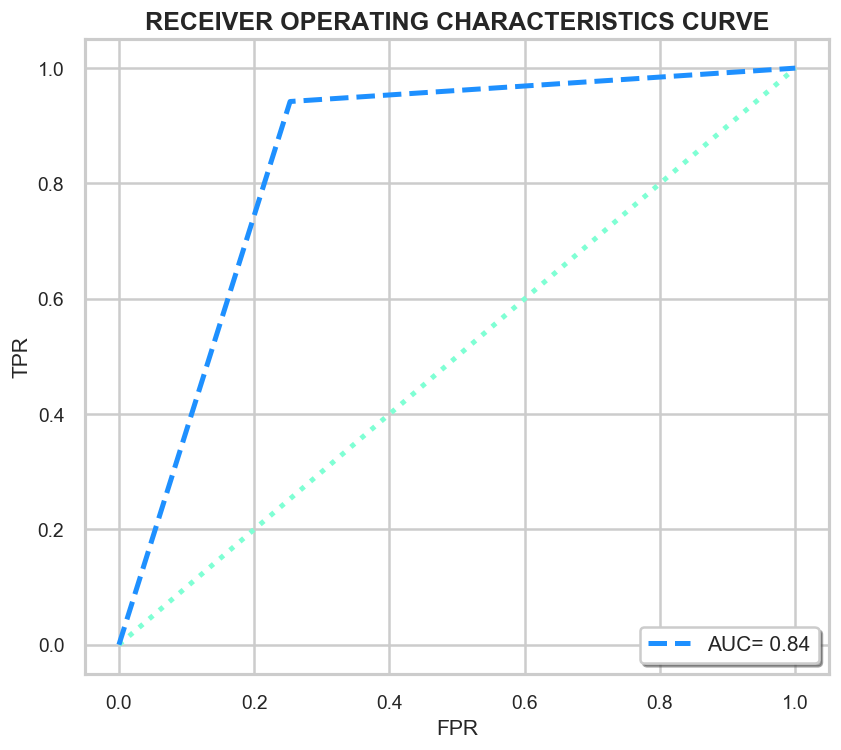

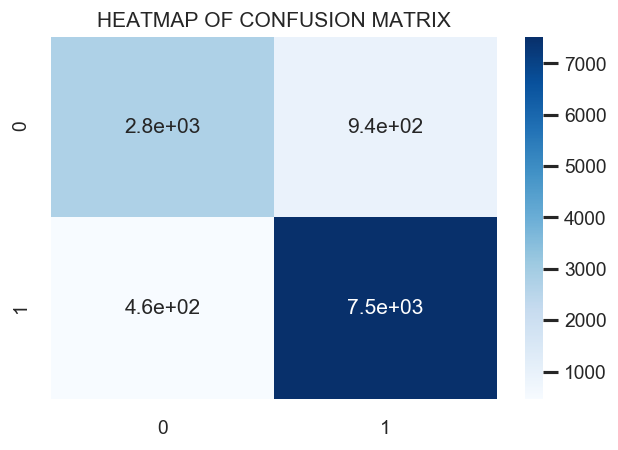

In [29]:
logi=LogisticRegression(max_iter=600,warm_start=True)
acusr(logi,x,y)

In [30]:
nb=MultinomialNB()
params = {'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]}
mnb = gsv(nb,params,scoring='f1_weighted', cv=50)
mnb.fit(x,y)
print(mnb)
print('\nbest_score=',mnb.best_score_)
print('\nbest_parameters=',mnb.best_params_)

GridSearchCV(cv=50, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

best_score= 0.8526778657127513

best_parameters= {'alpha': 0.1}


In this MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True) 
RANDOM STATE:
 80

ACCURACY SCORE:
 0.8627568493150685

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.66      0.75      3699
           1       0.86      0.95      0.90      7981

    accuracy                           0.86     11680
   macro avg       0.86      0.81      0.83     11680
weighted avg       0.86      0.86      0.85     11680


CONFUSION MATRIX:
 [[2448 1251]
 [ 392 7589]]

PRECISION:
 0.8584841628959275

RECALL:
 0.9508833479513845

MEAN SQUARED ERROR:
 0.14066780821917807

ROOT MEAN SQ. ERROR:
 0.37505707328242466


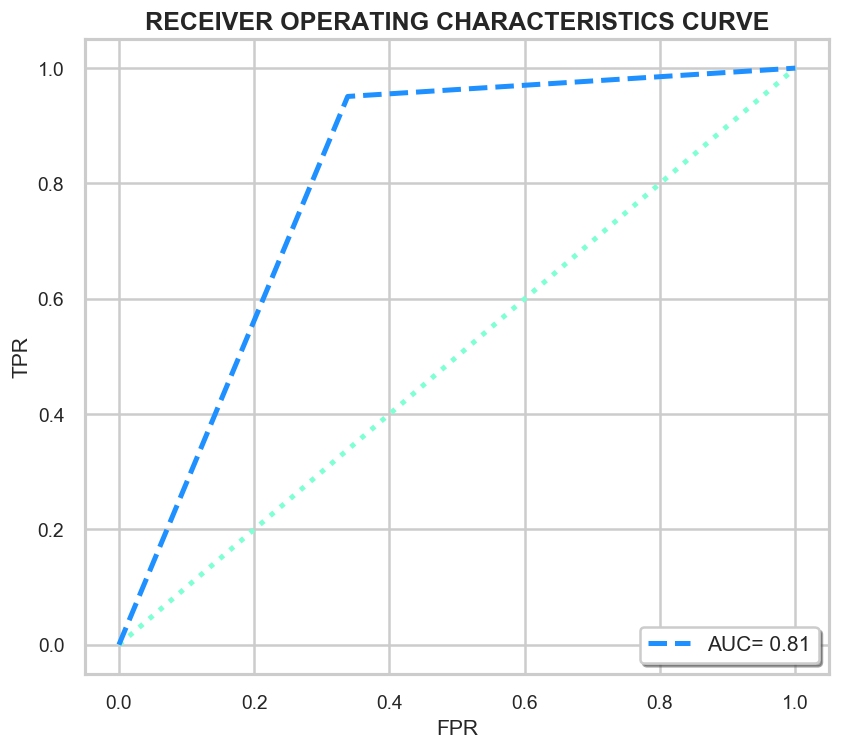

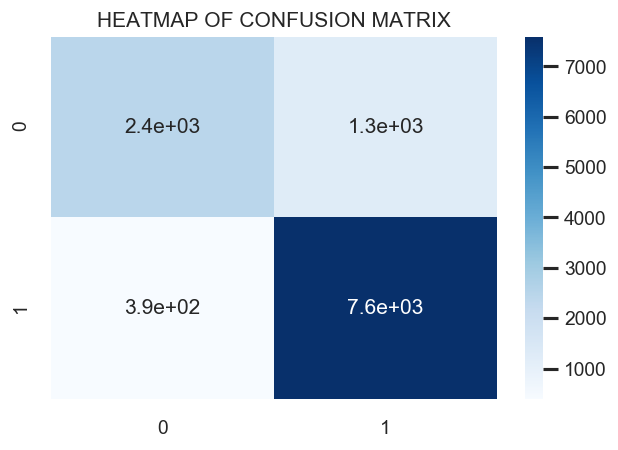

In [31]:
nb=MultinomialNB(alpha=0.1)
acusr(nb,x,y)

In [32]:
#COMPLEMENT NB

In [33]:
NB_Params = {'alpha': [0.1,  0.9, 1.0]}

cnb = ComplementNB()
cnb_gsv = gsv(cnb, NB_Params, cv=20)
cnb_gsv.fit(x,y)
print(cnb_gsv)
print('\nbest_score=',cnb_gsv.best_score_)
print('\nbest_parameters=',cnb_gsv.best_params_)

GridSearchCV(cv=20, error_score=nan,
             estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                                    norm=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.9, 1.0]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

best_score= 0.8602435902917552

best_parameters= {'alpha': 0.9}


In this ComplementNB(alpha=0.9, class_prior=None, fit_prior=True, norm=False) 
RANDOM STATE:
 80

ACCURACY SCORE:
 0.8619006849315068

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.62      0.73      3699
           1       0.85      0.96      0.90      7981

    accuracy                           0.85     11680
   macro avg       0.86      0.79      0.81     11680
weighted avg       0.86      0.85      0.85     11680


CONFUSION MATRIX:
 [[2300 1399]
 [ 312 7669]]

PRECISION:
 0.8457212174680194

RECALL:
 0.9609071544919183

MEAN SQUARED ERROR:
 0.14648972602739727

ROOT MEAN SQ. ERROR:
 0.382739762798951


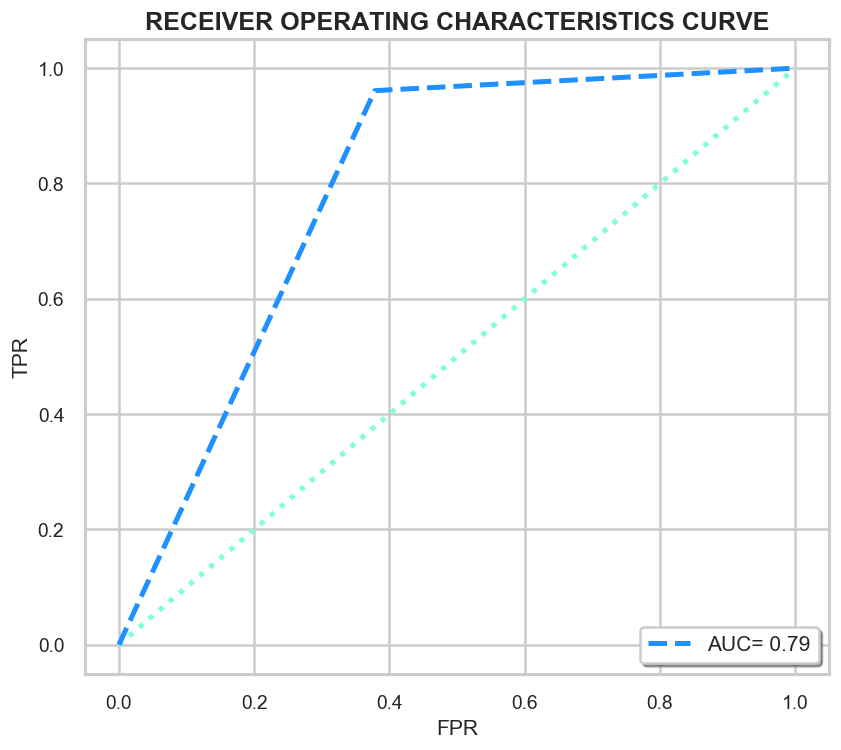

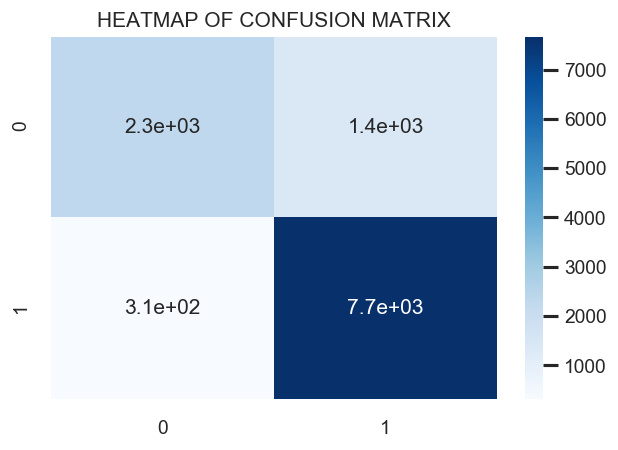

In [34]:
cnb = ComplementNB(alpha=0.9)
acusr(cnb,x,y)

In [35]:
rfc=RandomForestClassifier()
rfc_para={"n_estimators":[200,350],'max_depth':[6,9],'criterion':('gini','entropy')}
rfc_gsv=gsv(rfc,rfc_para,cv=50)
rfc_gsv.fit(x,y)
print(rfc_gsv)
print('\nbest score=',rfc_gsv.best_score_)
print('\nbest parameters for RFC=\n',rfc_gsv.best_params_)

GridSearchCV(cv=50, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In this RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
RANDOM STATE:
 62

ACCURACY SCORE:
 0.7028253424657535

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.03      0.05      3699
           1       0.69      1.00      0.82      7981

    accuracy                           0.69     11680
   macro avg       0.84      0.51      0.43     11680
weighted avg       0.79      0.69      0.57     11680


CONFUSION MATRIX:
 [[  97 3602]
 [   0 

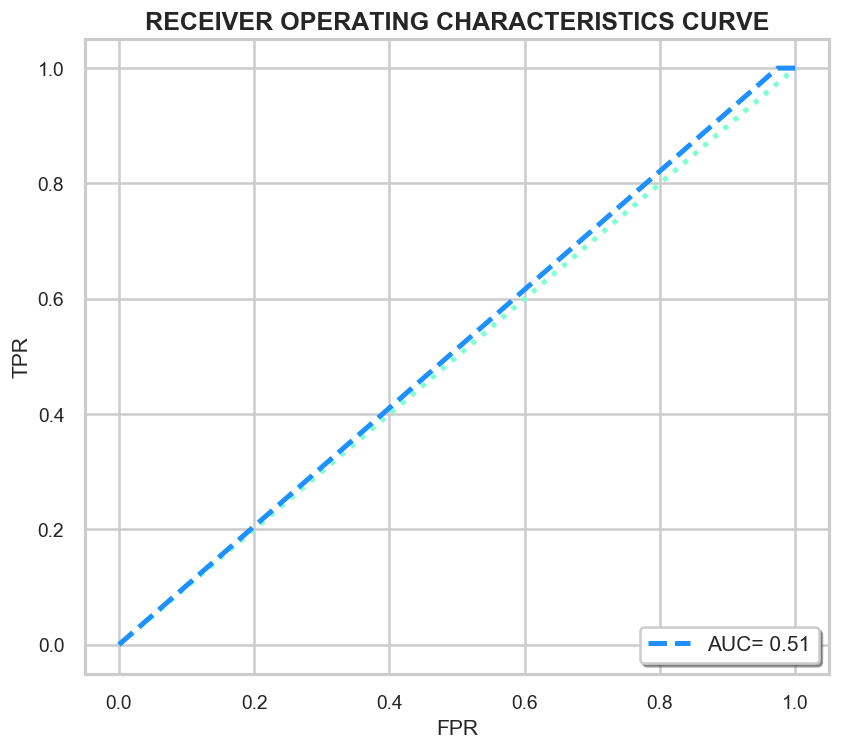

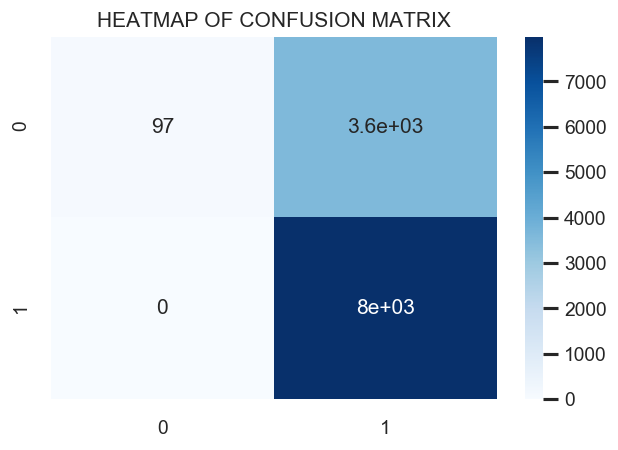

In [36]:
rfc=RandomForestClassifier(n_estimators=200,max_depth=9,criterion='gini')
acusr(rfc,x,y)

In [37]:
#RESULTS

In [39]:
model=["LOGISTIC",'MNB','CNB','RANDOM FOREST']
results = pd.DataFrame({"MODEL":model,'Accuracy':ACCURACY,'Precision': PRECISION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,"ROC_AUC":ROC_AUC})
                               
                                
            
results.style.set_properties(**{'background-color':'darkslategrey','color': 'springgreen','border-color': 'darkorange'})


,MODEL,Accuracy,Precision,Recall,RMSE,MSE,ROC_AUC
0,LOGISTIC,0.880308,0.889296,0.942113,0.345965,0.119692,0.844536
1,MNB,0.859332,0.858484,0.950883,0.375057,0.140668,0.806342
2,CNB,0.853510,0.845721,0.960907,0.382740,0.146490,0.791348
3,RANDOM FOREST,0.691610,0.689027,1.000000,0.555329,0.308390,0.513112


In [41]:
logi

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

In [42]:
import joblib
joblib.dump(logi,'HOTEL_LOGIST.pkl')

['HOTEL_LOGIST.pkl']

In [43]:
hotel_sentiment=joblib.load("HOTEL_LOGIST.pkl")

In [45]:
#importing test file
test=pd.read_csv(r"D:\Fliprobo\projects\projects\Project_1\test.csv")
test.head(5)

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [46]:
test.shape

(29404, 4)

In [47]:
#DROPPING UNWANTED
test.drop(['User_ID','Browser_Used','Device_Used'],axis=1,inplace=True)


In [48]:
#CREATING A COLUMN TO CHECK THE LENGTH OF EACH ROW OF DESCRIPTION COLUMN
test['len_uncleaned desc']=test['Description'].str.len()
test.head(3)


,Description,len_uncleaned desc
0,Looking for a motel in close proximity to TV t...,676
1,Walking distance to Madison Square Garden and ...,588
2,Visited Seattle on business. Spent - nights in...,863


In [49]:
#CONVRTING EVERYTHING TO LOWERCASE
test['Description']=test['Description'].str.lower()

#REPLACING NEXT LINES BY WHITE SPACE
test['Description']=test['Description'].str.replace(r'\n'," ") 

#REPLACING SPECIAL CHARACTERS AND NUMBERS BY WHITE SPACE IT ALSO REMOVES THE PUNCTUATIONS
test['Description']=test['Description'].str.replace(r"[^a-zA-Z]+", " ") #removing all special characters

In [50]:
#PREVIEW AFTER LOWER CASE CONVERSION AND REMOVAL OF UNWANTED CHARACTERS
print(test['Description'][2:8])

2    visited seattle on business spent nights in th...
3    this hotel location is excellent and the rooms...
4    this hotel is awesome i love the service antho...
5    rooms concierge services and party scene were ...
6    what a pleasant place to stay the hotel is bea...
7    i booked out the same day i arrived it cost me...
Name: Description, dtype: object


In [51]:
%%time
cleaned_test = []

for i in test['Description']:
    cleaned_test.append(clean(i))

Wall time: 15min 29s


In [52]:
#ADDING THE EXTRACTED FEATURES TO THE DATAFRAME



#creating a dataframe with a variable name 'processed'
processed = pd.DataFrame({'cleaned_description':cleaned_test})  

 #concatenating test and processed dataframe
test = pd.concat([test, processed], axis = 1) 


#creating a new column containing length of cleaned description
test['len_cleaned_description']=test['cleaned_description'].str.len() 
test.sample(5)

,Description,len_uncleaned desc,cleaned_description,len_cleaned_description
16892,my husband and i showed up for out first overn...,689,husband show first overnight three little kid ...,376
17202,affordable clean great location and nice ameni...,76,affordable clean great location nice amenities...,51
12225,interesting property nice location lobby area ...,508,interest property nice location lobby area wel...,295
6654,i stayed here for a week with my boyfriend it ...,527,stay week boyfriend nice hotel room little sma...,317
4927,i visited dc for a week for work and i was blo...,540,visit dc week work blow away nearly everything...,305


In [53]:
x_tr=tfidf(input='content', encoding='utf-8', lowercase=True,stop_words='english').fit(train['cleaned_description'])

In [54]:
x_tst=x_tr.transform(test['cleaned_description'])
x_tst

<29404x38774 sparse matrix of type '<class 'numpy.float64'>'
	with 1601014 stored elements in Compressed Sparse Row format>

In [55]:
predict=hotel_sentiment.predict(x_tst)
predict

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [56]:
#saving the result to csv
np.savetxt('hotel_sentiment.csv', predict, delimiter=',', fmt='%d')